## Yuvoh - Data Scientist Challenge


### Data Pre-processing and Feauture Engeneering

After the data exploration, we are ready to do data preparation and feauture engineering for modeling as following: 

* Convert categorical variables from object to categorical type
* Convert datatime variable from object to datatime type
* Missing data imputation
* Categorical variables encoding
* Create new features if needed

The resulted dataframe is saved to train and target data sets to be used in the modeling and model evaluation step

In [1]:
%matplotlib inline 
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib._color_data as mcd
from datetime import datetime,timedelta
from sklearn.feature_extraction import FeatureHasher
import category_encoders as ce

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('listings_reduced.csv')
data.head()

#data.shape
# (83830, 35)

,id,experiences_offered,host_since,host_response_time,host_response_rate,host_listings_count,host_verifications,neighbourhood_cleansed,latitude,longitude,...,calendar_updated,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_private_rooms
0,13913,business,2009-11-16,within a few hours,86%,4.0,"['email', 'phone', 'facebook', 'reviews']",Islington,51.56802,-0.11121,...,2 months ago,19,347,16,2,2010-08-18,2019-06-10,moderate,3,2
1,15400,romantic,2009-12-05,within a day,100%,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",Kensington and Chelsea,51.48796,-0.16898,...,2 months ago,1,203,85,4,2009-12-21,2019-05-05,strict_14_with_grace_period,1,0
2,17402,none,2010-01-04,within an hour,85%,19.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",Westminster,51.52098,-0.14002,...,today,3,269,41,12,2011-03-21,2019-06-19,strict_14_with_grace_period,14,0
3,24328,family,2009-09-28,within a day,100%,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",Wandsworth,51.47298,-0.16376,...,4 months ago,1,329,93,1,2010-11-15,2019-06-08,moderate,1,0
4,25023,none,2010-04-03,within a few hours,100%,1.0,"['email', 'phone', 'reviews']",Wandsworth,51.44687,-0.21874,...,3 weeks ago,1,2,28,3,2016-03-05,2019-06-22,moderate,1,0


#### Assessing Missing data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83830 entries, 0 to 83829
Data columns (total 35 columns):
id                                              83830 non-null int64
experiences_offered                             83830 non-null object
host_since                                      83783 non-null object
host_response_time                              59051 non-null object
host_response_rate                              59051 non-null object
host_listings_count                             83783 non-null float64
host_verifications                              83830 non-null object
neighbourhood_cleansed                          83830 non-null object
latitude                                        83830 non-null float64
longitude                                       83830 non-null float64
property_type                                   83830 non-null object
room_type                                       83830 non-null object
accommodates                                    8

,Total,Percent
security_deposit,29472,35.156865
host_response_time,24779,29.558631
host_response_rate,24779,29.558631
cleaning_fee,21570,25.730645
last_review,21018,25.072170
first_review,21018,25.072170
beds,140,0.167005
bathrooms,138,0.164619
host_since,47,0.056066
host_listings_count,47,0.056066


<Figure size 1080x432 with 0 Axes>

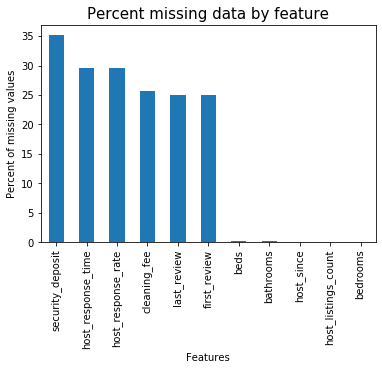

In [4]:
total_nan = data.isna().sum().sort_values(ascending=False)
percent_nan = (100*data.isna().sum()/data.isna().count()).sort_values(ascending=False)

missing_data = pd.concat([total_nan, percent_nan], axis=1, keys=['Total', 'Percent'])#reset_index #
#missing_data.columns = ['Features','Total', 'Percent']

over_zero=missing_data[missing_data.Total > 0]

plt.figure(figsize=(15,6))
#plt.subplots(figsize=(15, 6))
over_zero.plot.bar(rot=0,y='Percent',legend = False) #x=missing_data.index, y=missing_data['Percent']
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of missing values',fontsize=10)
plt.title('Percent missing data by feature',fontsize=15)
plt.show

#missing_data
over_zero

#### Processing the data with Date type

Starting with date type. Date type variables are converted to datatime type and then replace null values 

The null values are placed as following:
* **host_since**:  replace with **first_review** value less 2 weeks if not null, otherwise today date less 2 weeks.
* **first_review**: replace with **host_since** value plus 2 weeks
* **last_review**: replace with **first_review**

It better works with number of days rather than the date. Hence 3 new variables are created representing each date variable.

In [5]:
#Covert variables to datatime

data['host_since'] =  pd.to_datetime(data['host_since'], format='%Y-%m-%d')
data['first_review'] =  pd.to_datetime(data['first_review'], format='%Y-%m-%d')
data['last_review'] =  pd.to_datetime(data['last_review'], format='%Y-%m-%d')

#Replace null values for host_since
time_diff = timedelta(weeks=-2)
today = datetime.now()
#Replace null data with 2 weeks before of first_review
data.loc[data['host_since'].isnull(),'host_since'] = data['first_review'] + time_diff 
#still some null data. Replace with last 2 weeks from now
data.loc[data['host_since'].isnull(),'host_since'] = today.date() + time_diff

data.loc[data['first_review'].isnull(),'first_review'] = data['host_since'] - time_diff 
data.loc[data['last_review'].isnull(),'last_review'] = data['first_review']

#Create new variables with number of days until now
data['days_as_host'] = (today.date() - data['host_since'].dt.date).dt.days
data['days_first_review'] = (today.date() - data['first_review'].dt.date).dt.days
data['days_last_review'] = (today.date() - data['last_review'].dt.date).dt.days

data[['first_review','last_review','host_since','days_as_host','days_first_review','days_last_review']].head()

,first_review,last_review,host_since,days_as_host,days_first_review,days_last_review
0,2010-08-18,2019-06-10,2009-11-16,3656,3381,163
1,2009-12-21,2019-05-05,2009-12-05,3637,3621,199
2,2011-03-21,2019-06-19,2010-01-04,3607,3166,154
3,2010-11-15,2019-06-08,2009-09-28,3705,3292,165
4,2016-03-05,2019-06-22,2010-04-03,3518,1355,151


#### Replace symbols and convert to float. Missing data imputation

Imputation is the method of estimating missing values in a data set.

Starting with removing symbols for some variavles. The variables relate to money have the symbol **\$** which need to be removed. Those variables are converted to float. Also one variable contain the **%** symbol. This symbol is removed as well

These variables has missing data. The mice imputation is used to estimate missing values. It is done at the end of this notebook.

In [6]:
data["security_deposit"]= data["security_deposit"].str.replace('[$,]', '', regex=True).astype(float)
data["cleaning_fee"]= data["cleaning_fee"].str.replace('[$,]', '', regex=True).astype(float)
data["extra_people"]= data["extra_people"].str.replace('[$,]', '', regex=True).astype(float)

#deposit_agg = data.groupby('price')['security_deposit'].agg(['mean', 'median','min','max','std']).reset_index()
#dcleaning_agg = data.groupby('price')['cleaning_fee'].agg(['mean', 'median','min','max','std']).reset_index()
#print(deposit_agg.head(20))
#dcleaning_agg.head(20)

#host_response_rate - remove % and conver to number
data['host_response_rate'] = data['host_response_rate'].str.replace('%', '', regex=True).astype('float')

The host_response_time is a categorical variable with missing data. The missing data is imputed with a new category callesd 'unknow'

In [7]:
#fill missinga data as 'unknow' for host_response_time or imputation: mode
data['host_response_time'] = data['host_response_time'].fillna('unknow')
data['host_response_time'] = data['host_response_time'].astype('category')

The missing data for the 'bathrooms','bedrooms', 'beds' variables is imputed with the median. In this case the median is better option than the media as descriptive statistic shows 

In [8]:
#Missing data for 'bathrooms','bedrooms', 'beds'
#Descritive statistics for those varaibles
#Replace missing data with median

print(data[['bathrooms','bedrooms', 'beds']].median())
print(data[['bathrooms','bedrooms', 'beds']].describe())

data[['bathrooms','bedrooms', 'beds']]=data[['bathrooms','bedrooms', 'beds']].apply(lambda x: x.fillna(x.median()),axis=0)
data[['bathrooms','bedrooms', 'beds']].describe()

bathrooms    1.0
bedrooms     1.0
beds         1.0
dtype: float64
          bathrooms      bedrooms          beds
count  83692.000000  83796.000000  83690.000000
mean       1.297310      1.414650      1.749468
std        0.617887      0.926028      1.284259
min        0.000000      0.000000      0.000000
25%        1.000000      1.000000      1.000000
50%        1.000000      1.000000      1.000000
75%        1.500000      2.000000      2.000000
max       24.000000     24.000000     55.000000


,bathrooms,bedrooms,beds
count,83830.000000,83830.000000,83830.000000
mean,1.296821,1.414482,1.748217
std,0.617496,0.925878,1.283551
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.500000,2.000000,2.000000
max,24.000000,24.000000,55.000000


#### Categorical data encoding

* Several categorical variables
* Some of them have large number of categories (high cardinality)
* To avoid large increase of new variables, we used
  * ordinal encoding for 'room_type' and 'cancellation_policy' as they values show
  * Reduce categories for neibourhood then create dummy variables
  * mean encoding for the rest

In [9]:
print("Number of categories for each categorical variable\n")
print("Number of unique categories for property_type: ", len(data['property_type'].unique()))
print(data['property_type'].unique())
print("\nNumber of unique categories for experiences_offered: ",len(data['experiences_offered'].unique()))
print(data['experiences_offered'].unique())
print("\nNumber of unique categories for bed_type: ",len(data['bed_type'].unique()))
print(data['bed_type'].unique())
print("\nNumber of unique categories for host_response_time: ",len(data['host_response_time'].unique()))
print(data['host_response_time'].unique())
print("\nNumber of unique categories for room_type: ",len(data['room_type'].unique()))
print(data['room_type'].unique())
print("\nNumber of unique categories for cancellation_policy: ",len(data['cancellation_policy'].unique()))
print(data['cancellation_policy'].unique())
print("\nNumber of unique categories for neighbourhood_cleansed: ",len(data['neighbourhood_cleansed'].unique()))
print(data['neighbourhood_cleansed'].unique())

Number of categories for each categorical variable

Number of unique categories for property_type:  40
['Apartment' 'Townhouse' 'House' 'Condominium' 'Serviced apartment'
 'Bed and breakfast' 'Aparthotel' 'Loft' 'Other' 'Guest suite' 'Boat'
 'Bungalow' 'Cottage' 'Guesthouse' 'Villa' 'Cabin' 'Yurt' 'Hostel'
 'Parking Space' 'Tiny house' 'Nature lodge' 'Camper/RV' 'Hut'
 'Boutique hotel' 'Houseboat' 'Hotel' 'Chalet' 'Earth house' 'Lighthouse'
 'Barn' 'Ryokan (Japan)' 'Casa particular (Cuba)' 'Island' 'Treehouse'
 'Farm stay' 'Bus' 'Campsite' 'Tent' 'Plane' 'Dome house']

Number of unique categories for experiences_offered:  5
['business' 'romantic' 'none' 'family' 'social']

Number of unique categories for bed_type:  5
['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']

Number of unique categories for host_response_time:  5
[within a few hours, within a day, within an hour, a few days or more, unknow]
Categories (5, object): [within a few hours, within a day, within an hour, a few day

In [10]:
#mean encoding
mean_price = data['price'].mean()
agg = data.groupby('property_type')['price'].agg(['count','mean'])
smoothed_mean = (agg['count']* agg['mean']+ mean_price * 100)/(agg['count'] * 100)
data.loc[:,'property_type_mean_enc'] = data['property_type'].map(smoothed_mean)

agg = data.groupby('experiences_offered')['price'].agg(['count','mean'])
smoothed_mean = (agg['count']* agg['mean']+ mean_price * 100)/(agg['count'] * 100)
data.loc[:,'experiences_offered_mean_enc'] = data['experiences_offered'].map(smoothed_mean)

agg = data.groupby('bed_type')['price'].agg(['count','mean'])
smoothed_mean = (agg['count']* agg['mean']+ mean_price * 100)/(agg['count'] * 100)
data.loc[:,'bed_type_mean_enc'] = data['bed_type'].map(smoothed_mean)

agg = data.groupby('host_response_time')['price'].agg(['count','mean'])
smoothed_mean = (agg['count']* agg['mean']+ mean_price * 100)/(agg['count'] * 100)
data.loc[:,'host_response_time_enc'] = data['host_response_time'].map(smoothed_mean)
data['host_response_time_enc'] = data['host_response_time_enc'].astype('float')

#converting 'room_type' to ordinal numbers
room = {'Shared room':1, 'Private room':2,'Entire home/apt':3 }
data['room_type_ord'] = data['room_type'].map(room)

#converting 'cancellation_policy' to ordinal numbers
policy = {'flexible':1, 'moderate':2,'luxury_moderate':3,'strict':4,
          'strict_14_with_grace_period':5,'super_strict_30':6,
          'super_strict_30':7,'luxury_super_strict_95':8
         }
#fill null with mode
data['cancellation_policy'].fillna((data['cancellation_policy'].mode()[0]), inplace=True)
data['cancellation_policy_ord'] = data['cancellation_policy'].map(policy)


Location is relevant for predicting the price. The original 33 categories for 'neighbourhood_cleansed' are reduce to 9 categories in the following way:
* Inner or Outer as prefix and then 
  * Central/Esat/West/North/South


In [11]:
dict_area = {'Westminster':'inner-central',
'Tower Hamlets':'inner-East',
'Hackney':'inner-East',
'Camden' :'inner-central',
'Kensington and Chelsea':'inner-central',
'Islington':'inner-central',
'Southwark':'inner-central',
'Lambeth':'inner-central',
'Wandsworth':'inner-South',
'Hammersmith and Fulham':'inner-West',
'Lewisham':'inner-East',
'Greenwich':'inner-East',
'City of London':'inner-central',
'Haringey':'Outer_North',
'Newham':'0uter-East',
'Ealing':'0uter-West',
'Brent':'0uter-West',
'Barnet':'0uter-North',
'Merton':'0uter-South',
'Waltham Forest':'0uter-East',
'Richmond upon Thames':'0uter-West',
'Croydon':'0uter-South',
'Hounslow':'0uter-West',
'Redbridge':'0uter-East',
'Bromley':'0uter-South',
'Enfield':'0uter-North',
'Hillingdon':'0uter-West',
'Kingston upon Thames':'0uter-South',
'Harrow':'0uter-West',
'Barking and Dagenham':'0uter-East',
'Sutton':'0uter-South',
'Bexley':'0uter-East',
'Havering':'0uter-East'}

data['neighbourhood_area'] = data['neighbourhood_cleansed'].replace(dict_area)

data[['neighbourhood_area','neighbourhood_cleansed']]

,neighbourhood_area,neighbourhood_cleansed
0,inner-central,Islington
1,inner-central,Kensington and Chelsea
2,inner-central,Westminster
3,inner-South,Wandsworth
4,inner-South,Wandsworth
...,...,...
83825,inner-central,Westminster
83826,inner-central,Islington
83827,inner-central,Islington
83828,inner-central,Islington


In [12]:
print("\nNumber of unique categories for neighbourhood_area: ",len(data['neighbourhood_area'].unique()))
print(data['neighbourhood_area'].unique())

#convert to dummy 
data = pd.get_dummies(data,prefix='neighbourhood', columns=['neighbourhood_area'])

data.shape


Number of unique categories for neighbourhood_area:  9
['inner-central' 'inner-South' '0uter-North' '0uter-East' '0uter-West'
 'Outer_North' 'inner-East' '0uter-South' 'inner-West']


(83830, 53)

#### Columns with list like values

The 'amenities' and 'host_verifications' variables have list like values. The number of amenities and theirs type should be relevant for the price prediction. Host veryfications type may not be relevant. 

For a quicker pre-processing, we decided to create number of amenites provide and number of way the host is verified. 

In [14]:
data['num_amenities'] = data.apply(lambda row: len(row['amenities'].split(',')), axis=1)
data['num_host_verifications'] = data.apply(lambda row: len(row['host_verifications'].split(',')), axis=1)

data[['amenities','host_verifications','num_host_verifications','num_amenities']].head()

,amenities,host_verifications,num_host_verifications,num_amenities
0,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...","['email', 'phone', 'facebook', 'reviews']",4,54
1,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...","['email', 'phone', 'reviews', 'jumio', 'govern...",5,25
2,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...","['email', 'phone', 'reviews', 'jumio', 'offlin...",9,30
3,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...","['email', 'phone', 'reviews', 'jumio', 'offlin...",6,26
4,"{TV,Wifi,Kitchen,""Free parking on premises"",El...","['email', 'phone', 'reviews']",3,21


#### Remove unnecessary variables

In [15]:
#Remove the old innecessary columns to remove
remove_cols=['first_review','last_review', 'host_since','property_type','amenities','host_verifications','calendar_updated',
 'cancellation_policy','neighbourhood_cleansed','room_type','bed_type','experiences_offered','host_response_time']

data.drop(remove_cols, axis=1, inplace=True)
data.shape

(83830, 42)

#### Multivariate imputation

The variables to be imputed are 'host_response_rate','host_listings_count','security_deposit','cleaning_fee'.

The package $impyute$ is used for multiple imputation. Find it at https://pypi.org/project/impyute/

In [16]:
#host_listings_count - 1.0
print(data[['host_listings_count']].isnull().sum())
print(data[['host_listings_count']].describe())
data['host_listings_count'].value_counts().sort_index()

host_listings_count    47
dtype: int64
       host_listings_count
count         83783.000000
mean             31.880632
std             172.829349
min               0.000000
25%               1.000000
50%               2.000000
75%               5.000000
max            1433.000000


0.0         494
1.0       39474
2.0       13004
3.0        5412
4.0        3087
          ...  
761.0         1
845.0         1
899.0         1
1071.0       72
1433.0     1161
Name: host_listings_count, Length: 100, dtype: int64

In [17]:
data[['host_response_rate','host_listings_count','security_deposit','cleaning_fee']].isnull().sum()

host_response_rate     24779
host_listings_count       47
security_deposit       29472
cleaning_fee           21570
dtype: int64

In [19]:
import impyute as impy

X = data.copy()  

y = X.price
X.drop('price',axis=1, inplace=True)
mice_X = impy.imputation.cs.mice(X)

cols=list(X.columns)
mice_X.columns = cols

In [20]:
#Copy the transformed dataset
mice_X.to_csv('train.csv',index=False)
y.to_csv('target.csv',index=False)